In [25]:
%matplotlib inline


# Optical Flow: Predicting movement with the RAFT model

Optical flow is the task of predicting movement between two images, usually two
consecutive frames of a video. Optical flow models take two images as input, and
predict a flow: the flow indicates the displacement of every single pixel in the
first image, and maps it to its corresponding pixel in the second image. Flows
are (2, H, W)-dimensional tensors, where the first axis corresponds to the
predicted horizontal and vertical displacements.

The following example illustrates how torchvision can be used to predict flows
using our implementation of the RAFT model. We will also see how to convert the
predicted flows to RGB images for visualization.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

c:\Users\Misha\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading Videos Using Torchvision
We will first read a video using :func:`~torchvision.io.read_video`.
Alternatively one can use the new :class:`~torchvision.io.VideoReader` API (if
torchvision is built from source).
The video we will use here is free of use from [pexels.com](https://www.pexels.com/video/a-man-playing-a-game-of-basketball-5192157/),
credits go to [Pavel Danilyuk](https://www.pexels.com/@pavel-danilyuk).



In [2]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve


video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)

:func:`~torchvision.io.read_video` returns the video frames, audio frames and
the metadata associated with the video. In our case, we only need the video
frames.

Here we will just make 2 predictions between 2 pre-selected pairs of frames,
namely frames (100, 101) and (150, 151). Each of these pairs corresponds to a
single model input.



In [21]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_path), output_format="THWC")

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

# plot(img1_batch)

In [ ]:
plot(img1_batch[0], cmap = 'gray')
plot(img2_batch[0])

In [24]:
img1_batch.shape

torch.Size([2, 720, 1280, 3])

In [23]:
frames.shape

torch.Size([333, 720, 1280, 3])

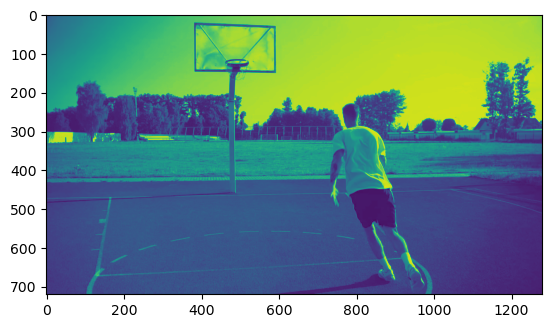

In [26]:
plt.imshow(frames[0,:,:,1])

torch.Size([2, 3, 720, 1280])


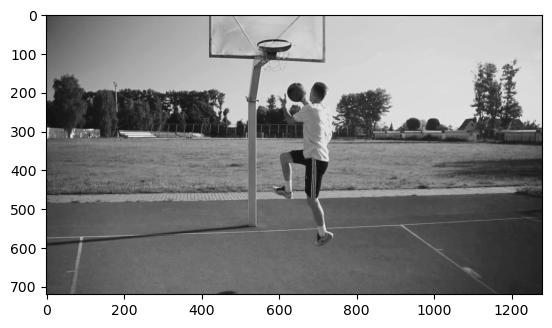

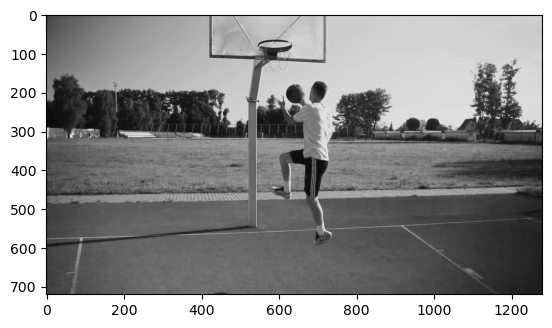

In [16]:
print(img1_batch.shape)
img1= img1_batch[0][0].numpy()[:,:]
img1.shape
img2= img2_batch[0][0].numpy()[:,:]
plt.imshow(img1, cmap = 'gray')
plt.show()
plt.imshow(img2, cmap = 'gray')
plt.show()

torch.Size([720, 1280, 3])


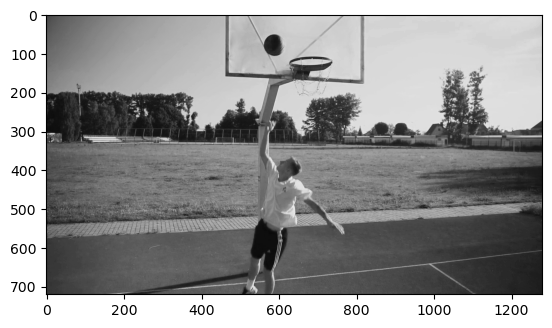

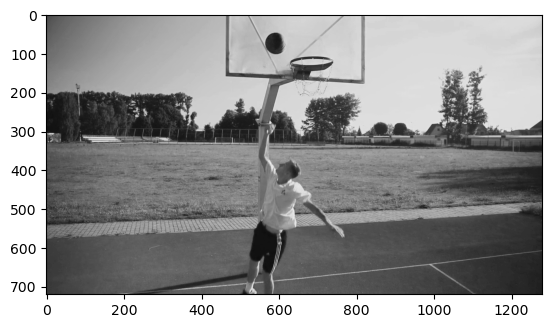

In [54]:
print(frames[100].shape)
img1= frames[150,:,:,0].numpy()[:,:]
img1.shape
img2= frames[151,:,:,0].numpy()[:,:]
plt.imshow(img1, cmap = 'gray')
plt.show()
plt.imshow(img2, cmap = 'gray')
plt.show()

In [55]:
from skimage import metrics as sm

print('Second image warped into the first:', sm.structural_similarity(img1,img2))

Second image warped into the first: 0.8294084534484836


In [33]:
frames.shape

torch.Size([333, 3, 720, 1280])

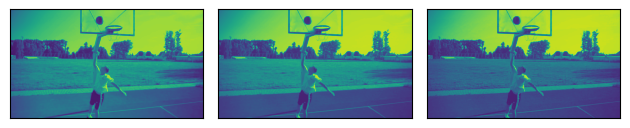

In [34]:
plot(frames[151])

The RAFT model accepts RGB images. We first get the frames from
:func:`~torchvision.io.read_video` and resize them to ensure their dimensions
are divisible by 8. Note that we explicitly use ``antialias=False``, because
this is how those models were trained. Then we use the transforms bundled into
the weights in order to preprocess the input and rescale its values to the
required ``[-1, 1]`` interval.



In [30]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

RuntimeError: The size of tensor a (720) must match the size of tensor b (3) at non-singleton dimension 1

## Estimating Optical flow using RAFT
We will use our RAFT implementation from
:func:`~torchvision.models.optical_flow.raft_large`, which follows the same
architecture as the one described in the [original paper](https://arxiv.org/abs/2003.12039).
We also provide the :func:`~torchvision.models.optical_flow.raft_small` model
builder, which is smaller and faster to run, sacrificing a bit of accuracy.



In [36]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device =  "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 71884800 bytes.

In [ ]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# print(device)

cpu


The RAFT model outputs lists of predicted flows where each entry is a
(N, 2, H, W) batch of predicted flows that corresponds to a given "iteration"
in the model. For more details on the iterative nature of the model, please
refer to the [original paper](https://arxiv.org/abs/2003.12039). Here, we
are only interested in the final predicted flows (they are the most acccurate
ones), so we will just retrieve the last item in the list.

As described above, a flow is a tensor with dimensions (2, H, W) (or (N, 2, H,
W) for batches of flows) where each entry corresponds to the horizontal and
vertical displacement of each pixel from the first image to the second image.
Note that the predicted flows are in "pixel" unit, they are not normalized
w.r.t. the dimensions of the images.



In [ ]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -43.86806869506836, max = 74.21932220458984


## Visualizing predicted flows
Torchvision provides the :func:`~torchvision.utils.flow_to_image` utlity to
convert a flow into an RGB image. It also supports batches of flows.
each "direction" in the flow will be mapped to a given RGB color. In the
images below, pixels with similar colors are assumed by the model to be moving
in similar directions. The model is properly able to predict the movement of
the ball and the player. Note in particular the different predicted direction
of the ball in the first image (going to the left) and in the second image
(going up).



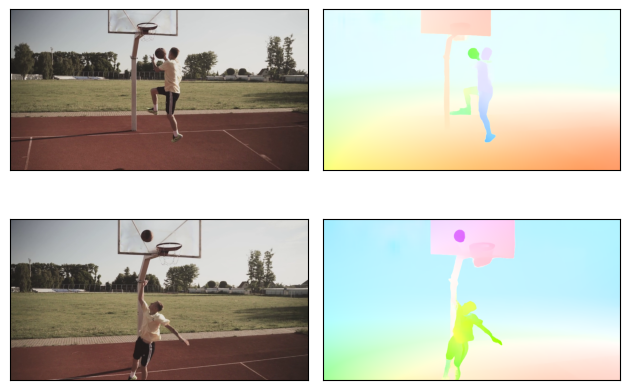

In [ ]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img_batch, flow_imgs)]
plot(grid)

## Bonus: Creating GIFs of predicted flows
In the example above we have only shown the predicted flows of 2 pairs of
frames. A fun way to apply the Optical Flow models is to run the model on an
entire video, and create a new video from all the predicted flows. Below is a
snippet that can get you started with this. We comment out the code, because
this example is being rendered on a machine without a GPU, and it would take
too long to run it.



In [ ]:
img1_batch.shape

torch.Size([2, 3, 520, 960])

In [ ]:
torch.cuda.is_available()

False

In [ ]:
# from torchvision.io import write_jpeg
# for i, (img1, img2) in enumerate(zip(frames[1:100], frames[1:101])):
#     # Note: it would be faster to predict batches of flows instead of individual flows
#     img1_ = torch.stack([img1, img2])
#     img2_ = torch.stack([img1, img2])
#     img1, img2 = preprocess(img1_, img2_)
#     print(img1.shape)
#     print(img2.shape)


#     list_of_flows = model(img1.to(device), img2.to(device))
#     predicted_flow = list_of_flows[-1][0]
#     flow_img = flow_to_image(predicted_flow).to("cpu")
#     output_folder = "C:/Users/Misha/OneDrive - University of Sussex/FYP"  # Update this to the folder of your choice
#     write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])
torch.Size([2, 3, 520, 960])


KeyboardInterrupt: 

Once the .jpg flow images are saved, you can convert them into a video or a
GIF using ffmpeg with e.g.:

ffmpeg -f image2 -framerate 30 -i predicted_flow_%d.jpg -loop -1 flow.gif

